[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Charlie5DH/WSN/blob/master/Notebooks/RSSI_Data_Exploration.ipynb)

Sequence to sequence or Seq2Seq is a neural network that transforms a given sequence, like words or time series, into another sequence. **Seq2seq models consist of an Encoder and Decoder, the Encoder takes the input sequence and maps it into a higher dimensional space.** The n-dimensional vector is taken by the Decoder and turned into an output sequence. The output sequence can be in another language, can be a symbol, etc.

A very basic choice for the Encoder and the Decoder of the Seq2Seq model is a single LSTM for each of them.

## Attention Interfaces

When I’m translating a sentence, I pay special attention to the word I’m presently translating. When I’m transcribing an audio recording, I listen carefully to the segment I’m actively writing down. And if you ask me to describe the room I’m sitting in, I’ll glance around at the objects I’m describing as I do so. NN can achieve this principle using **attention**. Focusing on a subset of information they are given. For example an RNN can attend over the output of another RNN.

We’d like attention to be differentiable, so that we can learn where to focus. To do this, we use the same trick Neural Turing Machines use: we focus everywhere, just to different extents.
![../Images/Untitled.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled.png?raw=1)

The attention distribution is usually generated with content-based attention. The attending RNN generates a query describing what it wants to focus on. Each item is dot-producted with the query to produce a score, describing how well it matches the query. The scores are fed into a softmax to create the attention distribution.

![../Images/Untitled%201.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%201.png?raw=1)

Say, we have a source sequence `x` (dates) of length `n` and try to output a target sequence `y` of length. `x = [x_1,...,x_n]` ; `y = [y1,...,y_m]`

The encoder is a bidirectional RNN (or other recurrent network setting of your choice) with a forward hidden state `h→i` and a backward one `h←i`. A simple concatenation of two represents the encoder state. The motivation is to include both the preceding and following words in the annotation of one word.

$$
h_i = [h_i^{\rightarrow T};h_i^{\leftarrow T}], i=1,...,nh_i = [h_i^{\rightarrow T};h_i^{\leftarrow T}], i=1,...,n
$$

The decoder has a **hidden state** $S_t=f(s_{t-1},y_{t-1}, c_t$ Which depends on the previous state, the previous output and a context vector for the output word at position `t`, $t=[t_1,...,t_m]$ where the context vector `C_t` is a sum of the hidden states of the input sequence weighted by alignment scores.

First calculate the attentions weights 
$$
\alpha=[\alpha_1,...\alpha_T] 
$$
based on the the encoded sequence `h=[h1,...h_T]` and the internal hidden state `S_{t-1}`.

![../Images/Untitled%203.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%203.png?raw=1)

The alignment model assigns a score `α_t,i` to the pair of input at position `i` and output at position `t`, `(y_t,x_i)`, based on how well they match. 

Below is a summary table of several popular attention mechanisms and corresponding alignment score functions:

![../Images/Untitled%205.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%205.png?raw=1)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.3.0


In [4]:
from IPython.display import HTML
from keras.utils.vis_utils import plot_model, model_to_dot
# this is for making Graphviz work (plot_model needs GraphViz)
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [5]:
### if running in Colab
!wget --no-check-certificate \
    https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
    -O /tmp/Features.csv

--2020-10-05 19:47:41--  https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qbn9y5ooqxipxki/single_feature.csv [following]
--2020-10-05 19:47:41--  https://www.dropbox.com/s/raw/qbn9y5ooqxipxki/single_feature.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3fa225f1b3d311d9611ab4c8b8.dl.dropboxusercontent.com/cd/0/inline/BAuQWw0UvSvEo1aTc8Q5UVPsIlooqANm-dPYhs5XGGQRbAg2RDQ75FXVv1dpx4YOk3HLZ6kJWUpMX_2oZAM3ap8s1qJmrJtP3GAtA5isXzTwZHZv5ZhbUcDUxqnaVaip8js/file# [following]
--2020-10-05 19:47:42--  https://uc3fa225f1b3d311d9611ab4c8b8.dl.dropboxusercontent.com/cd/0/inline/BAuQWw0UvSvEo1aTc8Q5UVPsIlooqANm-dPYhs5XGGQRbAg2RDQ75FXVv1dpx4YOk3HLZ6kJWUpMX_2oZAM3ap8s1qJ

In [9]:
data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')

In [10]:
# If running locally
def get_module_feature(module, features, path_of_file):
    
    df = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')
    try:
        df = df.drop(['Unnamed: 0'],axis=1)
    except:
        pass
    serie = df[df['Module']==module][features] 
    return serie

In [ ]:
# If Running Locally
path_of_file = '../../Features.csv'
data = get_module_feature(path_of_file=path_of_file, module='34.B2.9F.A9', features=['Temp_Mod','V_MPPT','V_Panel'])

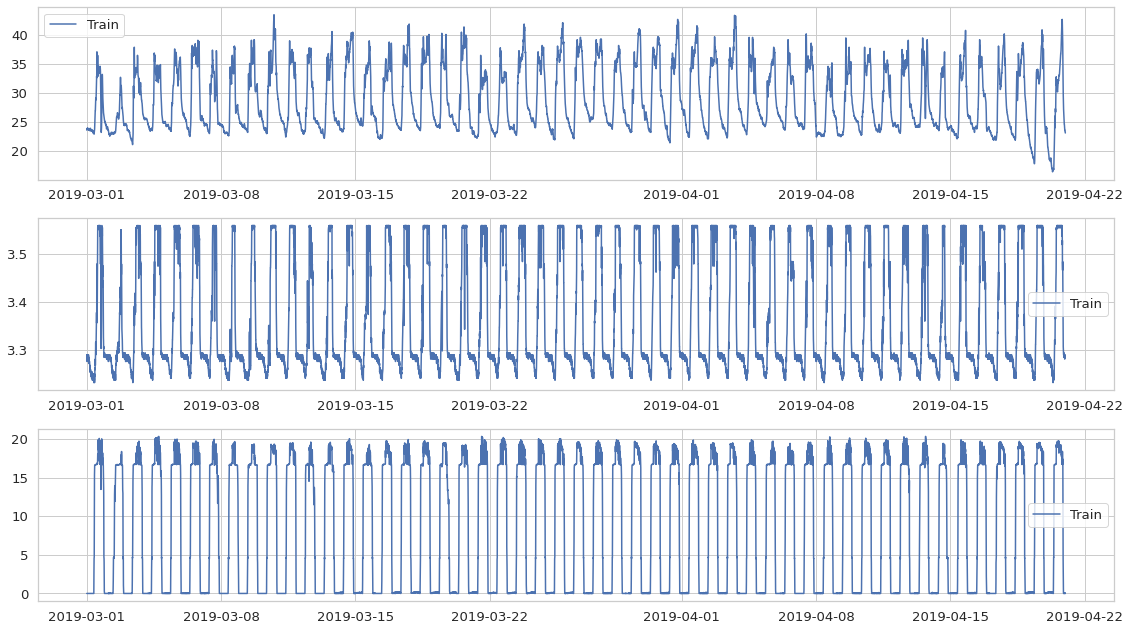

In [11]:
# The data is higly irregular so let's resample it to 1 hour and take the mean
#resampled = data.resample('60Min').mean()
#resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = data[init_date:end_date]

fig, axx = plt.subplots(3,1, figsize=(16,9))
for ii, ax in zip(train_data.columns, axx):
    ax.plot(train_data[ii], label='Train')
    ax.legend()
plt.tight_layout()

In [12]:
from sklearn.preprocessing import MinMaxScaler
train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

Lenght of Data 12592
Lenght of Train 10073


Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays.

## Create Sequences
Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3D numpy arrays. The function truncate generates 3 arrays:
- input to neural network X_in: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: detrended and normalised x1, detrended and normalised x2, and original assigned data position index. Only the first 2 features will be used for training.
- target in neural network X_out: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in X_in. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.
- label lbl: 1 for train set and 0 for test set.

In [13]:
x_labeled = np.column_stack([normalized_train, [1]*train_len+[0]*(len(normalized_train)-train_len)])
print(x_labeled.shape)

(12592, 4)


In [14]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_labeled, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(12373, 200, 3) (12373, 20, 3) (12373,)


In [15]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(9873, 200, 3) (9873, 20, 3)
(2500, 200, 3) (2500, 20, 3)


## Simple LSTM Seq2Seq
The output of an LSTM cell or layer of cells is called the hidden state.

**The encoder LSTM cell**: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.

**The decoder LSTM cell**: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

We use `return_state=True`. Keras provides the `return_state` argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c). This returns 3 arrays:
- The LSTM hidden state output for the last time step.
- The LSTM hidden state output for the last time step (again).
- The LSTM cell state for the last time step.

The hidden state and the cell state could in turn be used to initialize the states of another LSTM layer with the same number of cells.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 3)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41600       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

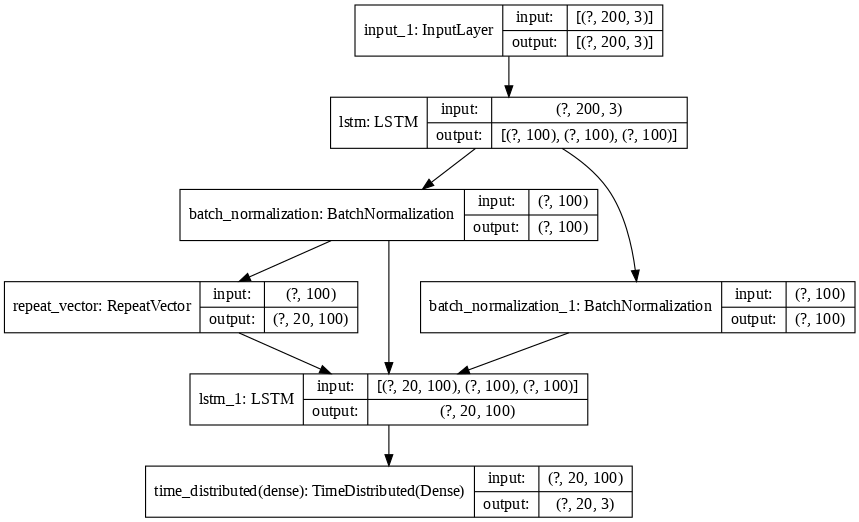

In [16]:
# Hidden Layers
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]))

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden, activation='relu', dropout=0.2,
                                                        recurrent_dropout=0.2, return_sequences=False,
                                                        return_state=True)(input_train)

# Batch normalisation is added because we want to avoid gradient
# explosion caused by the activation function ELU in the encoder.
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Create copies of las hidden state
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

# nitial_state: List of initial state tensors to be passed to the first call of the cell 
#(optional, defaults to None which causes creation of zero-filled initial state tensors).
# In this case initial state is the output from encoder
decoder = LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, 
               return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
model = Model(inputs=input_train, outputs=out)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [18]:
epochs = 20
batch_size = 100

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(X_input_train, X_output_train,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

Epoch 1/20
79/79 [==============================] - 56s 703ms/step - loss: 0.5274 - mae: 0.2037 - val_loss: 0.0222 - val_mae: 0.0961
Epoch 2/20
79/79 [==============================] - 55s 697ms/step - loss: 0.0277 - mae: 0.1068 - val_loss: 0.0443 - val_mae: 0.1358
Epoch 3/20
79/79 [==============================] - 55s 702ms/step - loss: 0.0225 - mae: 0.0938 - val_loss: 0.0592 - val_mae: 0.1510
Epoch 4/20
79/79 [==============================] - 55s 701ms/step - loss: 0.0183 - mae: 0.0829 - val_loss: 0.0350 - val_mae: 0.1130
Epoch 5/20
79/79 [==============================] - 55s 695ms/step - loss: 0.0176 - mae: 0.0807 - val_loss: 0.0555 - val_mae: 0.1435
Epoch 6/20
79/79 [==============================] - 57s 720ms/step - loss: 0.0164 - mae: 0.0767 - val_loss: 0.0172 - val_mae: 0.0761
Epoch 7/20
79/79 [==============================] - 56s 711ms/step - loss: 0.0146 - mae: 0.0730 - val_loss: 0.0161 - val_mae: 0.0746
Epoch 8/20
79/79 [==============================] - 56s 711ms/step - 

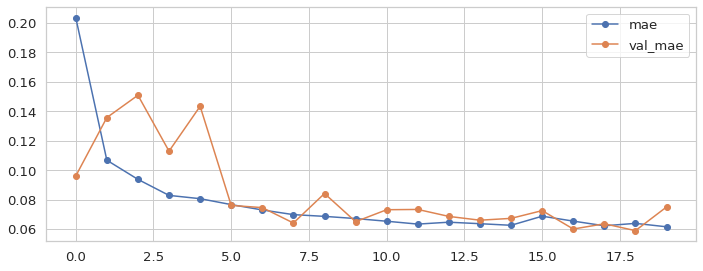

In [20]:
history_df.plot(figsize=(10,4), marker='o')
plt.tight_layout()

In [35]:
def serialize_model(model, history, name='model'):
    '''
    Save model and history
    '''
    # serialize model to JSON
    model_json = model.to_json()
    with open(name+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name+'.h5')
    history.to_csv(name+'.csv')
    print("Saved model to disk")

In [ ]:
name= 'Weights//model_seq2seq' + str(epochs)+ '_' + str(batch_size)
serialize_model(model, history_df, name= name)

Saved model to disk


In [ ]:
def load_model(name='model'):
    json_file = open(name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name+'.h5')
    print("Loaded model from disk")
    return loaded_model

In [ ]:
name= 'Weights/model_seq2seq' + str(epochs) + str(batch_size)
model=load_model(name)

Loaded model from disk


In [21]:
train_predictions = model.predict(X_input_train)
test_predictions = model.predict(X_input_test)

In [22]:
# X_output are the true values for the predictions
print(X_output_train.shape, X_output_test.shape)
print(train_predictions.shape, test_predictions.shape)

(9873, 20, 3) (2500, 20, 3)
(9873, 20, 3) (2500, 20, 3)


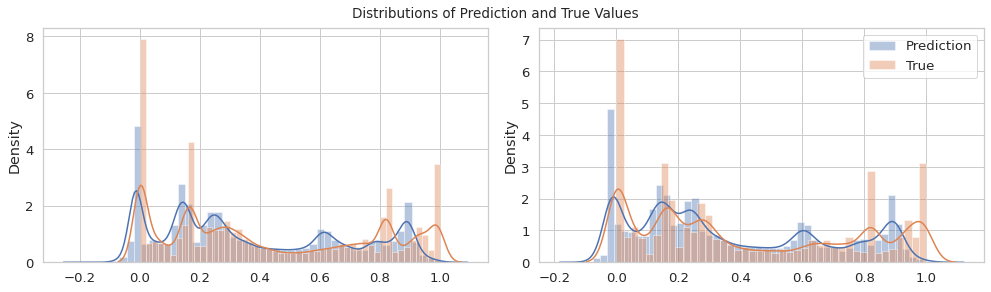

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
sns.distplot(a=X_output_train.flatten(), ax=ax1, label= 'True')
sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
sns.distplot(a=X_output_test.flatten(), ax=ax2, label='True')
plt.legend()
plt.tight_layout()

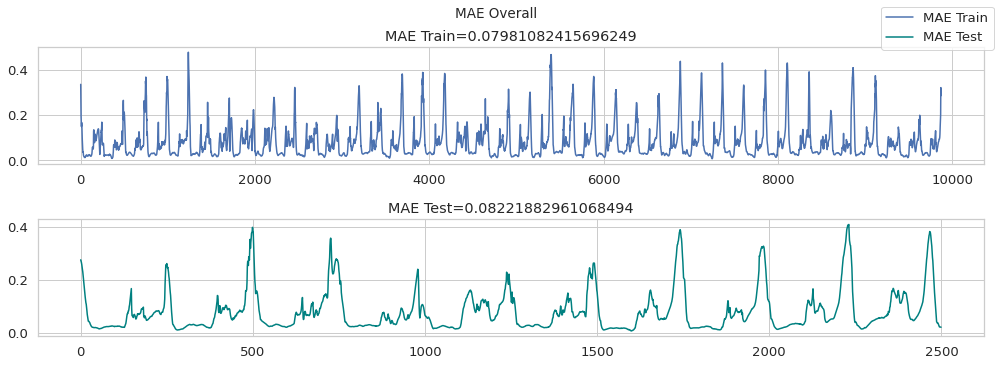

In [24]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,5))
fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)

MAE = abs(train_predictions - X_output_train).mean()
mae_overall = abs(train_predictions-X_output_train).mean(axis=(1,2))
ax1.plot(mae_overall, label='MAE Train')
ax1.set_title('MAE Train={}'.format(MAE))

MAE = abs(test_predictions - X_output_test).mean()
mae_overall = abs(test_predictions-X_output_test).mean(axis=(1,2))
ax2.plot(mae_overall, label='MAE Test', color='teal')
ax2.set_title('MAE Test={}'.format(MAE))

fig.legend(loc='upper right')
plt.tight_layout()

In [25]:
data_final = dict(train_pred=train_predictions, train_true=X_output_train,
                  test_pred=test_predictions, test_true=X_output_test)

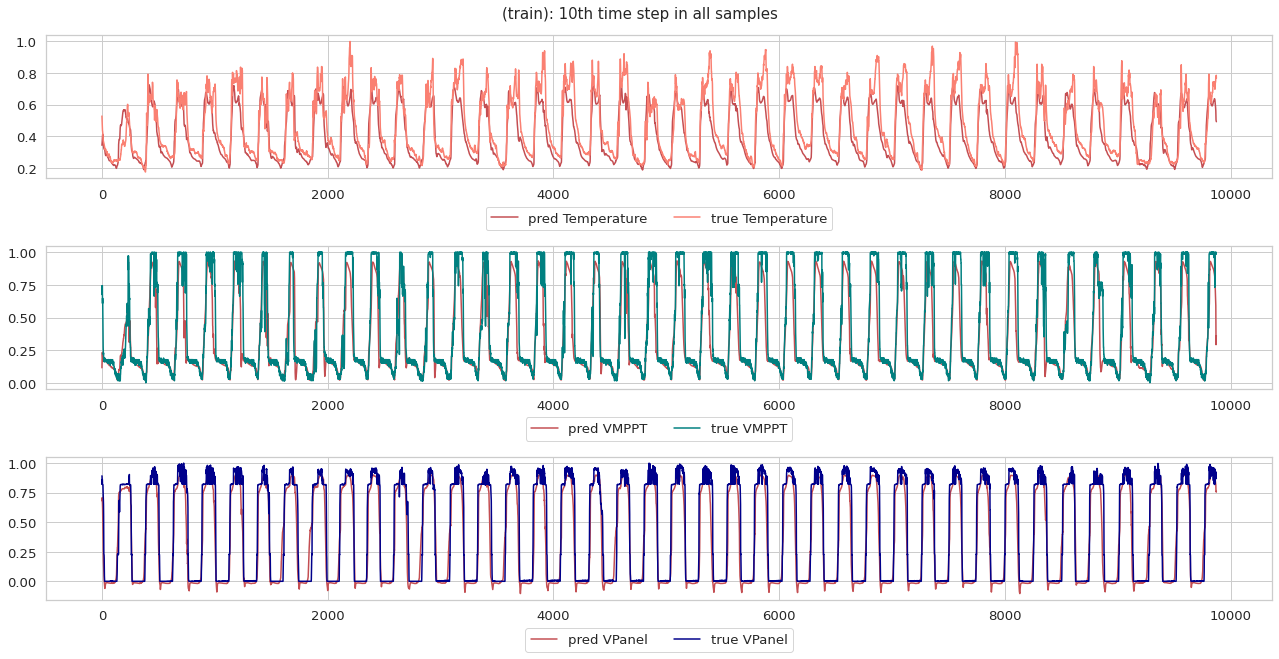

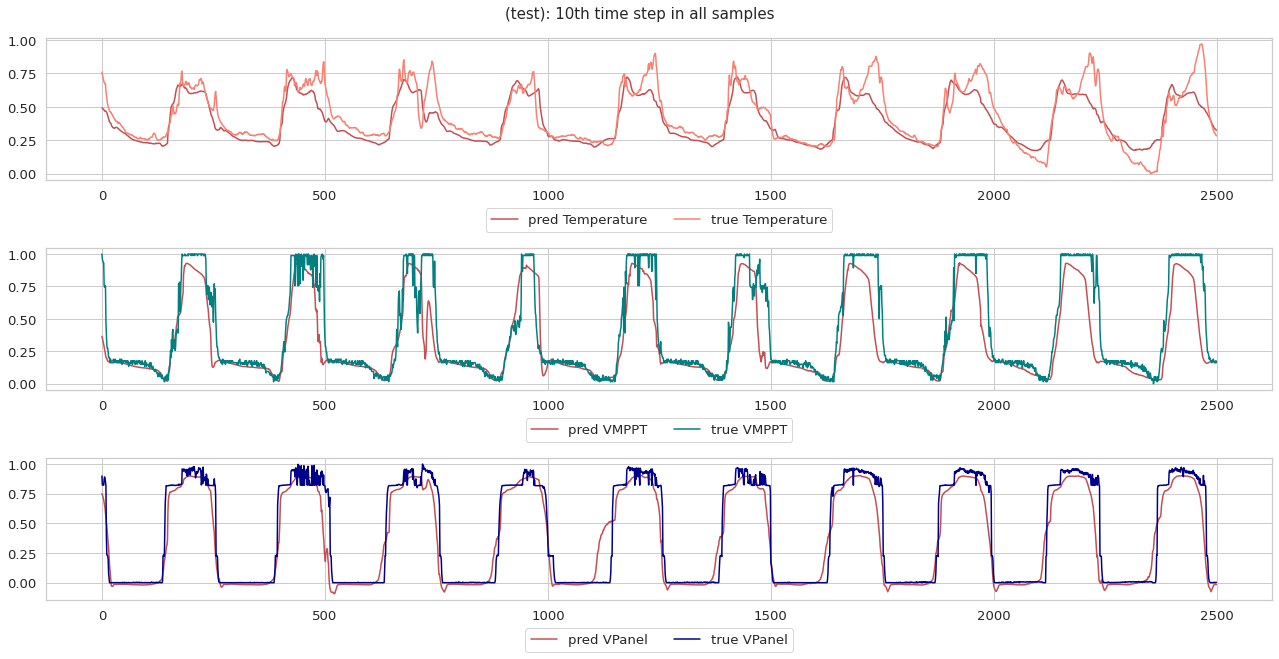

In [26]:
# Number of time steps in the future, as increases the accuracy decreases
ith_timestep = random.choice(range(data_final['train_pred'].shape[1]))

for lb in ['train', 'test']:   
    fig, axx = plt.subplots(3,1,figsize=(18,9))
    for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
        axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
        axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
        axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
    plt.tight_layout()

# Adding Luong Attention

One of the limitations of simple Seq2Seq model is: only the last state of encoder RNN is used as input to decoder RNN. If the sequence is very long, the encoder will tend to have much weaker memory about earlier time steps. Attention mechanism can solve this problem. An attention layer is going to assign proper weight to each hidden state output from encoder, and map them to output sequence.

In this case besides returning the last hidden state and the last cell state of the encoder, we also need to return the stacked hidden states for alignment score calculation. We need all the hidden states of the LSTM.

In [27]:
# Hidden Layers
n_hidden = 100
input_timesteps = X_input_train.shape[1]
input_features = X_input_train.shape[2]
output_timesteps = X_output_train.shape[1]
output_features = X_output_train.shape[2]

input_train = tf.keras.layers.Input(shape=(input_timesteps, input_features))
output_train = tf.keras.layers.Input(shape=(output_timesteps, output_features))

# The encoder now returns
encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(n_hidden, activation='relu',
                                                                       dropout=0.2, recurrent_dropout=0.2,
                                                                       return_sequences=True, 
                                                                       return_state=True)(input_train)

# Adding Batch Regularization to avoid gradient explotion(optional)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

print(input_train)
print(output_train)

Tensor("input_3:0", shape=(None, 200, 3), dtype=float32)
Tensor("input_4:0", shape=(None, 20, 3), dtype=float32)


In [28]:
# Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='relu',
                                       dropout=0.2, recurrent_dropout=0.2, return_state=False,
                                       return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)
print(decoder_input)

Tensor("lstm_3/transpose_1:0", shape=(None, 20, 100), dtype=float32)
Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)


### Attention Layer
To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [29]:
# Alignment Score is Dot Product in Luong Attention
attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax')(attention)
print(attention)

Tensor("activation/truediv:0", shape=(None, 20, 200), dtype=float32)


In [30]:
context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)


In [31]:
# Now we concat the context vector and stacked hidden states of decoder, 
# and use it as input to the last dense layer.
decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
print(decoder_combined_context)

out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("concatenate/concat:0", shape=(None, 20, 200), dtype=float32)
Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 3), dtype=float32)


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 3)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 200, 100), ( 41600       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_2[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_2[0][0]      
_______________________________________________________________________________________

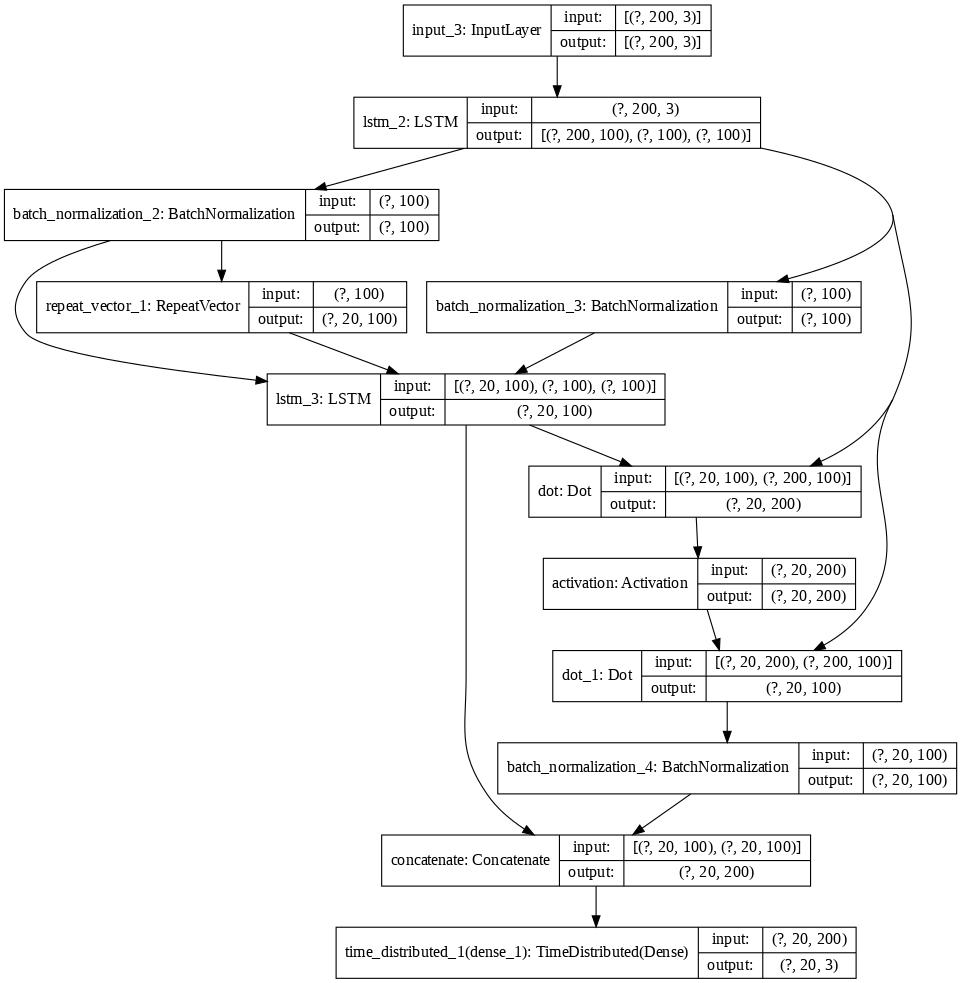

In [32]:
model = tf.keras.models.Model(inputs=input_train, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [33]:
epochs = 20
batch_size = 100

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(X_input_train, X_output_train,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

Epoch 1/20
79/79 [==============================] - 56s 713ms/step - loss: 0.4959 - mae: 0.1844 - val_loss: 0.0253 - val_mae: 0.1250
Epoch 2/20
79/79 [==============================] - 55s 692ms/step - loss: 0.0190 - mae: 0.0995 - val_loss: 0.0313 - val_mae: 0.1461
Epoch 3/20
79/79 [==============================] - 55s 696ms/step - loss: 0.0172 - mae: 0.0931 - val_loss: 0.0253 - val_mae: 0.1205
Epoch 4/20
79/79 [==============================] - 57s 717ms/step - loss: 0.0158 - mae: 0.0878 - val_loss: 0.0271 - val_mae: 0.1234
Epoch 5/20
79/79 [==============================] - 57s 726ms/step - loss: 0.0148 - mae: 0.0844 - val_loss: 0.0286 - val_mae: 0.1173
Epoch 6/20
79/79 [==============================] - 57s 725ms/step - loss: 0.0142 - mae: 0.0819 - val_loss: 0.0250 - val_mae: 0.1098
Epoch 7/20
79/79 [==============================] - 55s 702ms/step - loss: 0.0133 - mae: 0.0783 - val_loss: 0.0192 - val_mae: 0.1108
Epoch 8/20
79/79 [==============================] - 55s 691ms/step - 

In [38]:
name= '/tmp/model_seq2seq+att' + str(epochs)+ '_' + str(batch_size)
serialize_model(model, history_df, name= name)

Saved model to disk
